# Non-tagged Productivity in Article and Article Talk

This notebook is similar to 09-article-productivity.ipynb, except the data it uses is only for non-tagged edits.

We can only run this analysis on users who registered at a time when they could make tagged edits. I ran a query in Hive against `event.mediawiki_revision_tags_change` and found that the revision timestamp of the first tagged edit on one of our four target wikis is "2019-12-13T10:08:38Z". That edit was made on Arabic Wikipedia, by a user who registered about 45 minutes earlier. Based on that, I'll set the cutoff for registrations at 2019-12-13 09:00:00 UTC.

Because this timestamp is *after* the variant test started, it means that we take the variant test variable out of the models because it has no meaning (all users have it set to 1).

In [1]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
library(data.table)
library(ggplot2)

library(brms) # install.packages("brms")
library(loo) # install.packages("loo")
options(mc.cores = 4)
library(rstanarm) # install.packages("rstanarm")

Loading required package: Rcpp

Loading 'brms' package (version 2.14.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


This is loo version 2.3.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())


Attaching package: ‘rstanarm’


The following objects are masked from ‘package:brms’:

 

## Configuration variables

In [3]:
## Set BLAS threads to 4 so glmer and loo don't use all cores
library(RhpcBLASctl)
blas_set_num_threads(1)

## parallelization
options(mc.cores = 4)

### Data import and setup

In [4]:
nontagged_edit_data = fread(
    '/home/nettrom/src/Growth-homepage-2019/datasets/newcomer_tasks_nontagged_edits_nov2020.tsv',
    colClasses = c(wiki_db = 'factor'))

In [6]:
## Configuration variables for this experiment.
## Start timestamp is from https://phabricator.wikimedia.org/T227728#5680453
## End timestamp is from the data gathering notebook
start_ts = as.POSIXct('2019-11-21 00:24:32', tz = 'UTC')
end_ts = as.POSIXct('2020-04-9 00:00', tz = 'UTC')

## Start of the Variant A/B test
variant_test_ts = as.POSIXct('2019-12-13 00:32:04', tz = 'UTC')

## Convert user_registration into a timestamp
nontagged_edit_data[, user_reg_ts := as.POSIXct(user_registration_timestamp,
                                           format = '%Y-%m-%d %H:%M:%S.0', tz = 'UTC')]

## Calculate time since start of experiment in weeks
nontagged_edit_data[, exp_days := 0]
nontagged_edit_data[, exp_days := difftime(user_reg_ts, start_ts, units = 'days')]
nontagged_edit_data[exp_days < 0, exp_days := 0]
nontagged_edit_data[, ln_exp_days := log(1 + as.numeric(exp_days))]
nontagged_edit_data[, ln_exp_weeks := log(1 + as.numeric(exp_days)/7)]

## Calculate time since the start of the variant test, again in days and weeks.
## This enables us to do an interrupted time-series model for that.
nontagged_edit_data[, variant_exp_days := 0]
nontagged_edit_data[, variant_exp_days := difftime(user_reg_ts, variant_test_ts, units = 'days')]
nontagged_edit_data[variant_exp_days < 0, variant_exp_days := 0]
nontagged_edit_data[, ln_var_exp_days := log(1 + as.numeric(variant_exp_days))]
nontagged_edit_data[, ln_var_exp_weeks := log(1 + as.numeric(variant_exp_days)/7)]
nontagged_edit_data[, in_var_exp := 0]
nontagged_edit_data[user_reg_ts > variant_test_ts, in_var_exp := 1]

## Convert all NAs to 0, from
## https://stackoverflow.com/questions/7235657/fastest-way-to-replace-nas-in-a-large-data-table
na_to_zero = function(DT) {
  # or by number (slightly faster than by name) :
  for (j in seq_len(ncol(DT)))
    set(DT,which(is.na(DT[[j]])),j,0)
}

na_to_zero(nontagged_edit_data)

## Turn "reg_on_mobile" into a factor for more meaningful plots
nontagged_edit_data[, platform := 'desktop']
nontagged_edit_data[reg_on_mobile == 1, platform := 'mobile']
nontagged_edit_data[, platform := factor(platform)]

## Control variables for various forms of activation
nontagged_edit_data[, is_activated_article := num_article_edits_24hrs > 0]
nontagged_edit_data[, is_activated_other := num_other_edits_24hrs > 0]
nontagged_edit_data[, is_activated := is_activated_article | is_activated_other]

## Control variables for constructive forms of activation
nontagged_edit_data[, is_const_activated_article := (num_article_edits_24hrs - num_article_reverts_24hrs) > 0]
nontagged_edit_data[, is_const_activated_other := (num_other_edits_24hrs - num_other_reverts_24hrs) > 0]
nontagged_edit_data[, is_const_activated := is_const_activated_article | is_const_activated_other]

## Control variables for the number of edits made
nontagged_edit_data[, log_num_article_edits_24hrs := log(1 + num_article_edits_24hrs)]
nontagged_edit_data[, log_num_other_edits_24hrs := log(1 + num_other_edits_24hrs)]
nontagged_edit_data[, log_num_edits_24hrs := log(1 + num_article_edits_24hrs + num_other_edits_24hrs)]

## Control variables for the constructive number of edits made
nontagged_edit_data[, log_num_const_article_edits_24hrs := log(
    1 + num_article_edits_24hrs - num_article_reverts_24hrs)]
nontagged_edit_data[, log_num_const_other_edits_24hrs := log(
    1 + num_other_edits_24hrs - num_other_reverts_24hrs)]
nontagged_edit_data[, log_num_const_edits_24hrs := log(
    1 + num_article_edits_24hrs + num_other_edits_24hrs -
    num_article_reverts_24hrs - num_other_reverts_24hrs)]

## Retention variables
nontagged_edit_data[, is_const_retained_article := is_activated_article &
               ((num_article_edits_2w - num_article_reverts_2w) > 0)]
nontagged_edit_data[, is_const_retained_other := is_const_activated_other &
               ((num_other_edits_2w - num_other_reverts_2w) > 0)]
nontagged_edit_data[, is_const_retained := is_const_activated &
               ((num_article_edits_2w + num_other_edits_2w -
                 num_article_reverts_2w - num_other_reverts_2w) > 0)]

## Variables for number of edits (overall and only constructive)
## across the entire period.
nontagged_edit_data[, num_total_edits_24hrs := num_article_edits_24hrs + num_other_edits_24hrs]
nontagged_edit_data[, num_total_edits_2w := num_article_edits_2w + num_other_edits_2w]
nontagged_edit_data[, num_total_edits := num_total_edits_24hrs + num_total_edits_2w]

nontagged_edit_data[, num_total_const_edits_24hrs := (num_article_edits_24hrs + num_other_edits_24hrs -
                                                 num_article_reverts_24hrs - num_other_reverts_24hrs)]
nontagged_edit_data[, num_total_const_edits_2w := (num_article_edits_2w + num_other_edits_2w -
                                              num_article_reverts_2w - num_other_reverts_2w)]
nontagged_edit_data[, num_total_const_edits := num_total_const_edits_24hrs + num_total_const_edits_2w]

## Variables for number of article edits across the entire period.
nontagged_edit_data[, num_total_article_edits := num_article_edits_24hrs + num_article_edits_2w]

In [7]:
## Registration cutoff (see notes above)
reg_cutoff = as.POSIXct('2019-12-13 09:00:00', tz = 'UTC')

eligible_user_edit_data = nontagged_edit_data[user_reg_ts > reg_cutoff]

## Priors

In [8]:
## Note that using a student_t distribution for the prior is beneficial because that
## distribution handles outliers better than a Normal.
## See https://jrnold.github.io/bayesian_notes/robust-regression.html
## Thanks to Mikhail for sending that to me!
priors <- prior(cauchy(0, 2), class = sd) +
  prior(student_t(5, 0, 10), class = b)

## Edits across the entire 15-day period

We base this model on the same one used across all namespaces, meaning that we don't expect group-level variation in the effect of mobile. This is mainly because we have few wikis in our dataset, thus we don't expect that to contain meaningful information.

In [ ]:
nontagged_article_edits_all_days.zinb.mod.1 <- brm(
  bf(num_total_article_edits ~ is_treatment + reg_on_mobile + (1 | wiki_db),
     zi ~ wiki_db + reg_on_mobile),
    data = eligible_user_edit_data,
    family = zero_inflated_negbinomial(),
    prior = priors,
    iter = 800,
    control = list(adapt_delta = 0.999,
                 max_treedepth = 15)
)

Compiling Stan program...

Start sampling



In [ ]:
## Save the model
save(nontagged_article_edits_all_days.zinb.mod.1,
     file='models/nontagged_article_edits_all_days.zinb.mod.1.Robj')

In [15]:
summary(nontagged_article_edits_all_days.zinb.mod.1)

 Family: zero_inflated_negbinomial 
  Links: mu = log; shape = identity; zi = logit 
Formula: num_total_article_edits ~ is_treatment + reg_on_mobile + (1 | wiki_db) 
         zi ~ wiki_db + reg_on_mobile
   Data: eligible_user_edit_data (Number of observations: 85235) 
Samples: 4 chains, each with iter = 800; warmup = 400; thin = 1;
         total post-warmup samples = 1600

Group-Level Effects: 
~wiki_db (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.83      0.53     0.32     2.41 1.02      390      532

Population-Level Effects: 
                 Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept            0.21      0.50    -0.93     1.16 1.01      375      486
zi_Intercept        -2.11      0.12    -2.36    -1.88 1.00      957      931
is_treatment        -0.11      0.03    -0.16    -0.05 1.00     1495      943
reg_on_mobile        0.30      0.03     0.25     0.35 1.00     1684     1049
zi_wiki

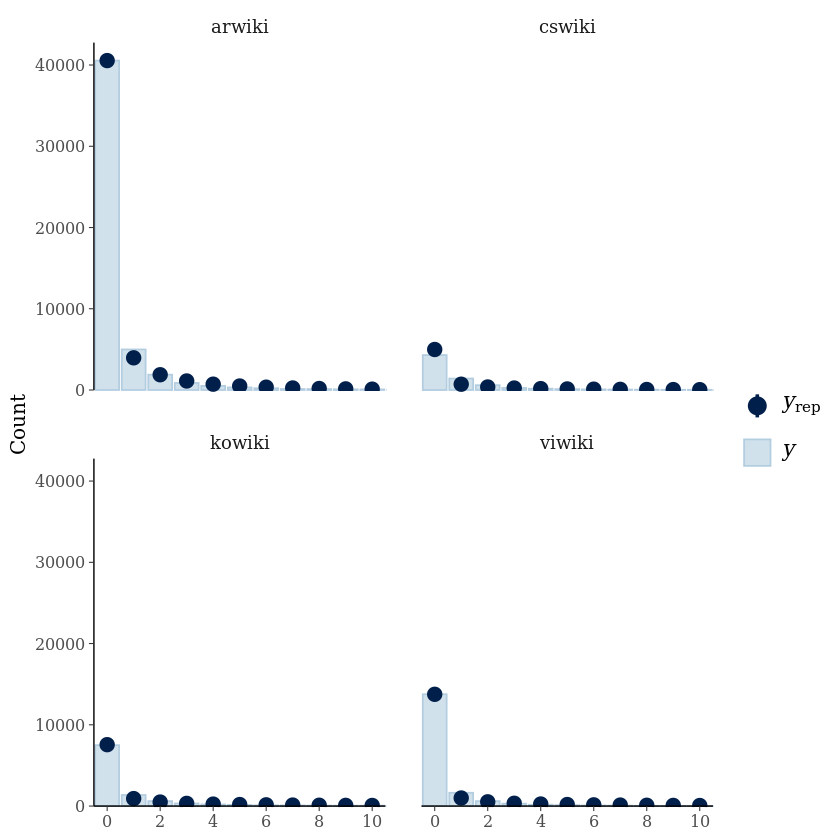

In [16]:
pp_check(nontagged_article_edits_all_days.zinb.mod.1, 
         nsamples = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(0, 10))

Zooming in on the non-zero part of the distributions, because the high zero-rate results in such a compressed graph.

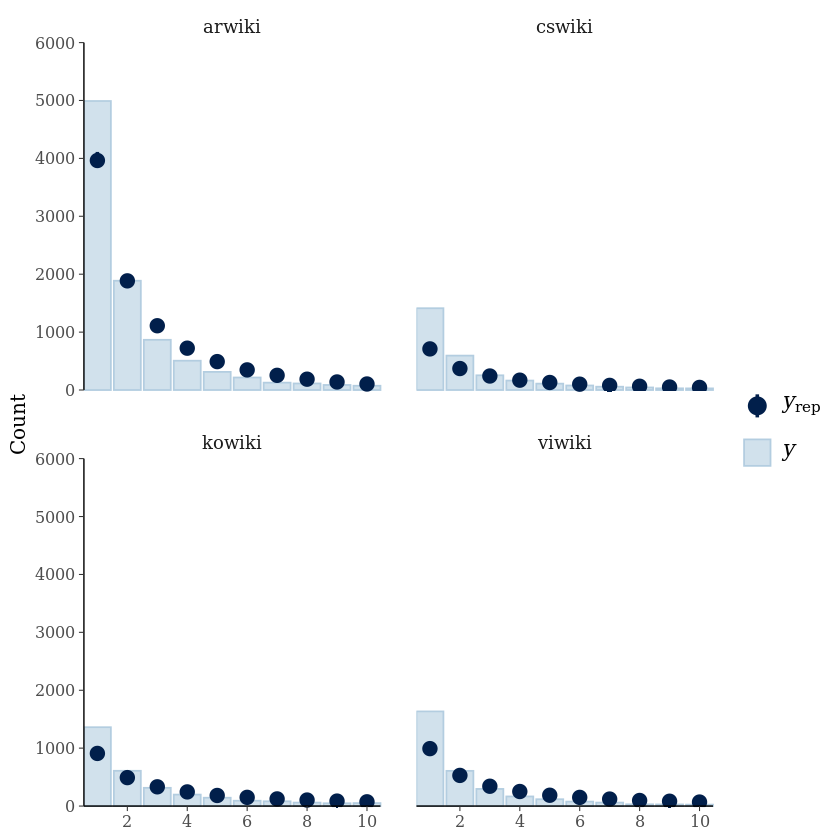

In [18]:
pp_check(nontagged_article_edits_all_days.zinb.mod.1, 
         nsamples = 100, type = "bars_grouped", group = "wiki_db") +
  ggplot2::coord_cartesian(xlim = c(1, 10), ylim = c(0, 6000))

We've seen this pattern before in the other productivity analyses that we've run. The model underestimates the number of ones somewhat, and sometimes also the number of twos, but higher counts appear to be quite accurate. I'm not particularly concerned about this, it'll instead be interesting to see whether we get closer fits later when we have datasets with more wikis in them.

## Estimated effects

First the average number of edits in the control group:

In [31]:
ctrl_grp_mean = exp(mean(log(1 + eligible_user_edit_data[is_treatment == 0]$num_total_article_edits))) -1
ctrl_grp_mean

[1] 0.3178318

The average number of edits in the Homepage group:

In [44]:
homepage_grp_mean = exp(fixef(nontagged_article_edits_all_days.zinb.mod.1, pars = 'is_treatment')[1] +
                        mean(log(1 + eligible_user_edit_data[is_treatment == 0]$num_total_article_edits))) -1
homepage_grp_mean

[1] 0.1859938

Let's find the 95% credible interval:

In [45]:
homepage_grp_low = exp(fixef(nontagged_article_edits_all_days.zinb.mod.1, pars = 'is_treatment')[3] +
                       mean(log(1 + eligible_user_edit_data[is_treatment == 0]$num_total_article_edits))) -1
homepage_grp_low

[1] 0.123566

In [46]:
homepage_grp_high = exp(fixef(nontagged_article_edits_all_days.zinb.mod.1, pars = 'is_treatment')[4] +
                        mean(log(1 + eligible_user_edit_data[is_treatment == 0]$num_total_article_edits))) -1
homepage_grp_high

[1] 0.2494115

In [47]:
(ctrl_grp_mean - homepage_grp_mean)

[1] 0.131838

In [48]:
(ctrl_grp_mean - homepage_grp_mean) / ctrl_grp_mean

[1] 0.4148042

In [49]:
(ctrl_grp_mean - homepage_grp_low)

[1] 0.1942658

In [50]:
(ctrl_grp_mean - homepage_grp_low) / ctrl_grp_mean

[1] 0.6112219

In [51]:
(ctrl_grp_mean - homepage_grp_high)

[1] 0.06842031

In [52]:
(ctrl_grp_mean - homepage_grp_high) / ctrl_grp_mean

[1] 0.2152721

In summary, we find that the control group makes an average of $0.32$ edits in the Article & Article talk namespaces. Note that the statistic reported in the Newcomer Tasks Experiment Analysis is $0.34$ edits, indicating slightly higher activity during the first three weeks of the experiment, while also suggesting that this statistic is accurate.

The Homepage group is estimated to make an average of $0.19$ non-tagged edits ($-0.13$ edits or $-41.5\%$). We're 95% confident the Homepage group's estimate is in the interval $[0.12, 0.25]$ edits, which is in the interval $[-0.19, -0.07]$ edits relative to the Control group, or $[-61.1\%, -21.5\%]$

In [54]:
## Get predictions from the model about what the expected number of edits
## are for a user in the Control and Homepage groups for all wikis.
predict_data = data.frame(
    wiki_db = c(rep('arwiki', 4), rep('cswiki', 4),
                rep('kowiki', 4), rep('viwiki', 4)),
    reg_on_mobile = rep(c(0, 0, 1, 1), 4),
    is_treatment = rep(c(0, 1), 8))

cbind(predict_data,
      round(predict(nontagged_article_edits_all_days.zinb.mod.1, predict_data, type = "response"), 1))

wiki_db,reg_on_mobile,is_treatment,Estimate,Est.Error,Q2.5,Q97.5
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
arwiki,0,0,0.6,1.7,0,6
arwiki,0,1,0.5,1.6,0,5
arwiki,1,0,0.8,2.4,0,7
arwiki,1,1,0.6,1.7,0,6
cswiki,0,0,1.5,4.0,0,13
cswiki,0,1,1.3,3.7,0,12
cswiki,1,0,2.1,5.3,0,17
cswiki,1,1,1.8,4.6,0,15
kowiki,0,0,2.2,5.6,0,19
